# SROP Winter 2025

### Dataset loading

In [203]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import tqdm
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torchsummary import summary
import struct

In [204]:
DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [205]:
train_dataset = torchvision.datasets.FashionMNIST(
    'data/', train=True, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)
test_dataset = torchvision.datasets.FashionMNIST(
    'data/', train=False, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

# Create a 10% validation set using stratification.
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify=train_dataset.targets,
    test_size=0.1
)
train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)

# # Update the training set transform to include data augmentation.
# augment_transform = torchvision.transforms.Compose([
#     torchvision.transforms.RandomHorizontalFlip(),
#     torchvision.transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=0.05),
#     torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1),
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize((0.1307,), (0.3081,))
# ])
# train_split.dataset.transform = augment_transform

# Create DataLoader objects.
train_batch_size = 512
test_batch_size  = 256
train_batches = DataLoader(train_split, batch_size=train_batch_size, shuffle=True)
val_batches   = DataLoader(val_split, batch_size=train_batch_size, shuffle=True)
test_batches  = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

print("Number of training batches:", len(train_batches))
print("Number of validation batches:", len(val_batches))
print("Number of test batches:", len(test_batches))

Number of training batches: 106
Number of validation batches: 12
Number of test batches: 40


Data is now formatted and loaded.

In [206]:
def set_color(r, g, b, bg=False):
    """
    Sets the text or background color using RGB values.

    Args:
        r: Red value (0-255).
        g: Green value (0-255).
        b: Blue value (0-255).
        bg: If True, sets the background color; otherwise, sets the text color.
    """
    type = 48 if bg else 38
    print(f"\033[{type};2;{r};{g};{b}m", end="")

In [207]:
with open('data/FashionMNIST/raw/train-images-idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    # print(data.shape) # (47040000,)
    Xtraindata = data.reshape((size, nrows*ncols))

with open('data/FashionMNIST/raw/train-labels-idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    Ylabeldata = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    # print(data.shape) # (47040000,)


traindata_imgs = np.transpose(Xtraindata).reshape((60000,28,28))

In [208]:
# imgIndex = 0

# for row in range(28):
#     for cell in range(28):
#         pixelBrightness = Xtraindata[imgIndex][row*28+cell]
#         set_color(pixelBrightness,pixelBrightness,pixelBrightness,True)
#         print(' * ',end='')
#     print()
# print(Ylabeldata[imgIndex])

In [209]:
number_of_components = 784
number_of_clusters = 10

In [210]:
# pca = PCA(n_components=number_of_components)
# reduced_data = pca.fit_transform(Xtraindata)
# pc_modes = pca.components_[:16]

# fig, axs = plt.subplots(4,4,figsize=(8,8))
# for i in range(4):
#     for j in range(4):
#         idx = i*4+j
#         axs[i,j].imshow(pc_modes[idx].reshape(28,28),cmap="gray")
#         axs[i,j].axis("off")
# fig.suptitle("First 16 PCA Modes",fontsize=20)
# plt.show()

In [211]:

# kmeans = KMeans(n_clusters=number_of_clusters,random_state=1).fit(reduced_data)
# cluster_centers = np.transpose(kmeans.cluster_centers_)[:2]


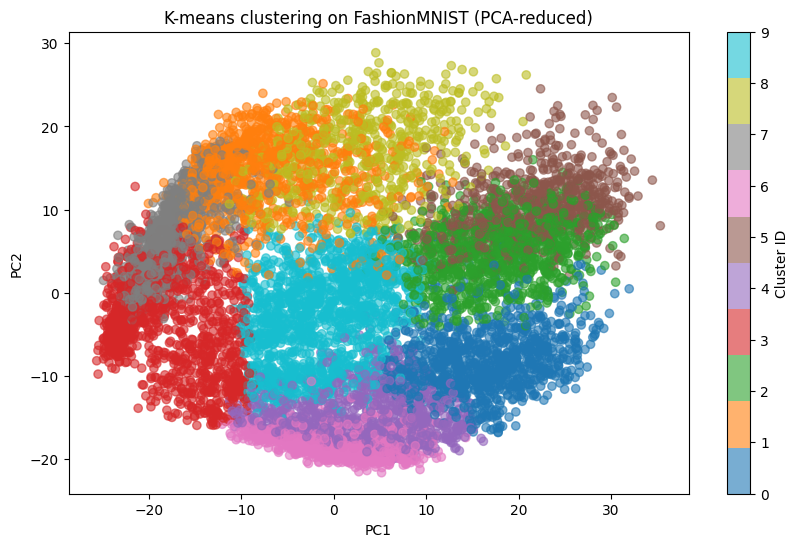

In [212]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def extract_flattened_data(dataloader, num_samples=10000):
    data_list = []
    label_list = []
    count = 0
    for imgs, labels in dataloader:
        imgs = imgs.view(imgs.size(0), -1)  # Flatten: (batch, 28*28)
        data_list.append(imgs)
        label_list.append(labels)
        count += imgs.size(0)
        if count >= num_samples:
            break
    X = torch.cat(data_list)[:num_samples]
    y = torch.cat(label_list)[:num_samples]
    return X.numpy(), y.numpy()
X_train, y_train = extract_flattened_data(train_batches, num_samples=10000)

kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
clusters = kmeans.fit_predict(X_train)
pca = PCA(n_components=number_of_components)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.6)
plt.title('K-means clustering on FashionMNIST (PCA-reduced)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='Cluster ID')
plt.show()

In [213]:
# plt.figure(figsize=(8, 6))
# plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=Ylabeldata, cmap='viridis', s=2)
# plt.scatter(cluster_centers[0],cluster_centers[1],s=100,c='black')
# plt.colorbar(label='Label')
# plt.title('PCA Reduced Data')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.show()

Now, let's evaluate the accuracy.

In [214]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

def clustering_accuracy(y_true, y_pred, n_clusters=10):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_clusters))
    
    row_ind, col_ind = linear_sum_assignment(-cm)  # maximize total matches
    
    total_correct = cm[row_ind, col_ind].sum()
    acc = total_correct / len(y_true)
    return acc, cm, row_ind, col_ind

acc, cm, row_ind, col_ind = clustering_accuracy(y_train, clusters, n_clusters=10)
print(f'Clustering Accuracy: {acc:.4f}')

Clustering Accuracy: 0.6188


In [215]:
# Validation set
X_val, y_val = extract_flattened_data(val_batches)
val_clusters = kmeans.predict(X_val)
val_acc, _, _, _ = clustering_accuracy(y_val, val_clusters)
print(f'Validation Clustering Accuracy: {val_acc:.4f}')

# Test set
X_test, y_test = extract_flattened_data(test_batches)
test_clusters = kmeans.predict(X_test)
test_acc, _, _, _ = clustering_accuracy(y_test, test_clusters)
print(f'Test Clustering Accuracy: {test_acc:.4f}')

Validation Clustering Accuracy: 0.6135
Test Clustering Accuracy: 0.6168


In [216]:
# predicted_labels = kmeans.fit_predict(reduced_data)

# # AI code to evaluate how well I did

# # Count elements in each cluster
# unique_clusters, counts = np.unique(predicted_labels, return_counts=True)
# print("\nCluster distribution:")
# for cluster, count in zip(unique_clusters, counts):
#     print(f"Cluster {cluster}: {count} samples")

# # Check how the clusters align with actual labels
# from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
# print(f"\nAdjusted Rand Index: {adjusted_rand_score(Ylabeldata, predicted_labels):.4f}")
# print(f"Normalized Mutual Information: {normalized_mutual_info_score(Ylabeldata, predicted_labels):.4f}")

# # Show majority class in each cluster
# print("\nDominant label in each cluster:")
# totPer = 0
# for cluster_id in range(number_of_clusters):
#     cluster_indices = np.where(predicted_labels == cluster_id)[0]
#     cluster_labels = Ylabeldata[cluster_indices]
#     unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)
#     dominant_label = unique_labels[np.argmax(label_counts)]
#     percentage = np.max(label_counts) / len(cluster_indices) * 100
#     totPer+=percentage
#     print(f"Cluster {cluster_id}: dominant class {dominant_label} ({percentage:.2f}%)")

In [217]:
with open('data/FashionMNIST/raw/t10k-images-idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    # print(data.shape) # (47040000,)
    Xtestdata = np.transpose(data.reshape((size, nrows*ncols)))

with open('data/FashionMNIST/raw/t10k-labels-idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    Ytestlabel = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    # print(data.shape) # (47040000,)